In [123]:
!pip install lmfit
!pip install tikzplotlib

%matplotlib inline
import numpy as np

import pandas as pd 
pd.__version__
from lmfit import models, Parameters, Model
import matplotlib.pyplot as plt
# Use the seborn style
#plt.style.use('seaborn')
import tikzplotlib
import re
from rdflib import Graph, Namespace, URIRef
from rdflib.namespace import RDF
def clean_string(string):
  return re.sub('[^A-Za-z0-9]+','', string )

In [173]:
#fetch sematic data and query for datasets and rois
PMD_CO=Namespace("https://w3id.org/pmd/co/")
OME=Namespace("https://github.com/Mat-O-Lab/OmeroExtractor/raw/main/ome.ttl#")
meta=Graph()
#meta.parse("https://github.com/BAMresearch/DF-TEM-PAW/raw/main/detection_runs-joined.ttl",format='turtle')
meta.parse("./detection_runs-joined.ttl")

meta.serialize('detection_runs-joined.ttl')

<Graph identifier=Ne9313afa758d4f9bbb617b30529e8d5e (<class 'rdflib.graph.Graph'>)>

In [218]:
from rdflib.plugins.sparql import prepareQuery
#datasets=[s for s,p,o in meta.triples((None,RDF.type,PMD_CO.Dataset))]
ome_dataset=URIRef("https://metadata.omero.matolab.org/api/dataset/53")
#get images for dataset and the attached roi iris 
#dataset=next(iter(datasets), None)
#print(dataset)
#ome_dataset=next(iter([s for s,p,o in meta.triples((None,PMD_CO.isResourceOf,dataset))]), None)
#print(ome_dataset)
#images=[o for s,p,o in meta.triples((ome_dataset,PMD_CO.isResourceOf,None))]
#ome_images=[s for s,p,o in meta.triples((None,PMD_CO.isResourceOf,None))]

q = prepareQuery(
    """
    SELECT DISTINCT ?ome_id ?imagedataset ?ome_image ?rois WHERE 
    {
          ?image ome:dataset ?imagedataset ;
            ome:rois ?rois.
          ?dataset co:isResourceOf ?imagedataset .

    }
    """
    ,
    initNs = { "co": PMD_CO, "ome": OME}
)
#result=meta.query(q, initBindings={'ome_id': ome_dataset})
result=meta.query(q)
for i,row in enumerate(result):
    print(i)
    print(row)
    if i>3:
        break
print(len(result))
# images_datasets=[(s,o) for s,p,o in meta.triples((None,OME.dataset,None))]
# datasets=[]
# #print(images_datasets[0])
# image=images[0][0]
# ome_image=next(iter(meta.subjects(PMD_CO.isRessourceOf,image)))
# rois=meta.value(image,OME.rois)
# ome_rois=next(iter(meta.subjects(PMD_CO.isRessourceOf,rois)))



0


In [222]:
q = prepareQuery(
    """
    SELECT ?image ?imagedataset ?ome_dataset ?ome_image ?rois ?ome_rois WHERE 
    {
          ?image ome:dataset ?imagedataset ;
            ome:rois ?rois.
          ?ome_image co:isRessourceOf ?image .
          ?ome_rois co:isRessourceOf ?rois .
          ?ome_dataset co:isRessourceOf ?imagedataset .
    }
    """
    ,
    initNs = { "co": PMD_CO, "ome": OME}
)
qres = meta.query(q)
for row in qres:
    print(row)
    break

In [199]:
images_imagedatasets=[(s,o) for s,p,o in meta.triples((None,OME.dataset,None))]
imagedataset=images_imagedatasets[0][1]
#print(images_imagedatasets)
datasets=[s for s,p,o in meta.triples((None,RDF.type,PMD_CO.Dataset))]
dataset=datasets[0]
#print(type(dataset),dataset)
ome_dataset=[s for s,p,o in meta.triples((None,PMD_CO.isRessourceOf,datasets[0]))][0]
#dataset=next(iter(meta.subjects(PMD_CO.isRessourceOf,imagedataset)))
image=images_imagedatasets[0][0]
ome_image=next(iter(meta.subjects(PMD_CO.isRessourceOf,image)))
rois=meta.value(image,OME.rois)
ome_rois=next(iter(meta.subjects(PMD_CO.isRessourceOf,rois)))
#print(image,dataset,ome_dataset,rois,ome_rois)

https://github.com/BAMresearch/DF-TEM-PAW/raw/main/detection_runs.csv/table-1-gid-0/darkfieldTransmissionElectronMicroscopeImage_ https://github.com/BAMresearch/DF-TEM-PAW/raw/main/detection_runs.csv/table-1-gid-0/imageDataset_ https://metadata.omero.matolab.org/api/dataset/53 https://github.com/BAMresearch/DF-TEM-PAW/raw/main/detection_runs.csv/table-1-gid-0/precipitateRegion_ https://metadata.omero.matolab.org/api/rois/83


In [12]:
#import data and create histograms
from os import listdir, path
max_x=12
min_x=0.0
bin_width=1.0
num_bins=int((max_x-min_x)/bin_width)
directory='./'
col_label_y='radius_in_nm'
#col_label_y='Radius [nm]'
plot_x_label="{}".format(col_label_y.replace('_',' '))
plot_y_label="normalized count"
filenames = listdir(directory)
plt.close('all')
datatofit={}
data={}
#plt.figure()
for file in filenames:
    if file.endswith(('.csv','.tra')):
        print(path.join(directory, file))
        filedata=pd.read_csv(path.join(directory, file),sep=';',decimal=',',header=[0,],encoding='utf-8')
        filedata.index.name='index'
        if col_label_y in filedata.columns:
          id=clean_string(file.rsplit('.',1)[0])
          count, bin_edges= np.histogram(filedata[col_label_y],bins=num_bins, range=(min_x,max_x))
          # calculate the centers of the bins
          bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
          hist=pd.DataFrame({'center': bin_centers, 'count': count})
          #print(hist.bin_edges)
          hist['norm']=hist['count']/hist['count'].sum()
          datatofit[id]=hist
          data[id]=filedata

./190c_1000h_1iteration.csv
./190c_2500h_1iteration.csv
./190C_250h_min_size.csv
./RockT61.csv
./T61_1iteration.csv


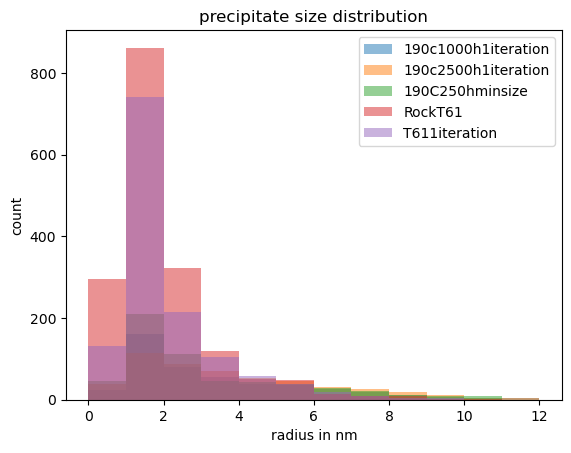

In [13]:
#plot all histograms
title='precipitate size distribution'
plt.figure()
for key, value in datatofit.items():
  plt.bar(value['center'], value['count'], width=bin_width, alpha=0.5,align='center',label=key)
  # plt.plot(value[col_label_x],value[col_label_y],label=key)
  plt.title(title)
  plt.xlabel(plot_x_label)
  plt.ylabel('count')
  plt.legend()
plt.show()
  #tikzplotlib.save("{}.tex".format(title.replace(' ','_')))

[[Model]]
    Model(rock)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 12
    # variables        = 2
    chi-square         = 0.00908716
    reduced chi-square = 9.0872e-04
    Akaike info crit   = -82.2295946
    Bayesian info crit = -81.2597813
[[Variables]]
    sigma:  0.68788497 +/- 0.04542636 (6.60%) (init = 0.5)
    rm:     2.39575023 +/- 0.16174822 (6.75%) (init = 3)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, rm) = 0.287


C:\Users\hanke\AppData\Local\Temp\ipykernel_16024\3859978165.py:9: RuntimeWarning: divide by zero encountered in divide
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_16024\3859978165.py:9: RuntimeWarning: divide by zero encountered in log
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))
C:\Users\hanke\AppData\Local\Temp\ipykernel_16024\3859978165.py:9: RuntimeWarning: invalid value encountered in multiply
  return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))


AttributeError: 'ModelResult' object has no attribute 'rsquared'

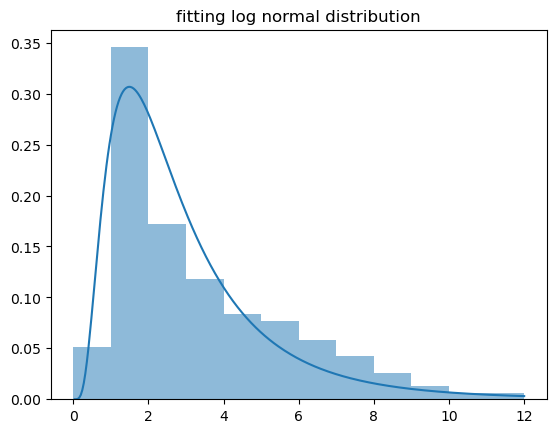

In [16]:
#results=pd.DataFrame(columns=('amplitude','amplitude stderr','center','center stderr','sigma','sigma stderr','fwhm','fwhm stderr','height','height stderr','chi squared'))
results=pd.DataFrame(columns=('rm','rm stderr','sigma','sigma stderr','ra','ra stderr','chi squared'))
start=0
end=max_x
x_sim=np.linspace(start,end,300)
def rock(x, rm, sigma):
    #return amp/(x*sigma*np.sqrt(2*np.pi))*np.exp((np.log(x/rm))**2/(2*sigma))
    #return amp/(x*sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x/rm))**2/(2*sigma))
    return 1.0/(np.sqrt(2*np.pi)*x*sigma)*np.exp(-(np.log(x/rm))**2/(2*sigma**2))

fits=dict()
#https://lmfit.github.io/lmfit-py/builtin_models.html#lognormalmodel
title="fitting log normal distribution"
for key, value in datatofit.items():
  x=value['center']
  y=value['norm']
  fit=pd.DataFrame(columns=('x','y','dely'))
  model = Model(rock)
  #params = model.make_params(sigma=3.0, rm=1.0)
  params = Parameters()
  #params.add('amp', value=1.0, min=1E-10, max=1E6, vary=False)
  params.add('sigma', value=0.5, min=0.1, max=1.0,vary=True)
  params.add('rm', value=3.0, min=0.5,max=100, vary=True)

  result = model.fit(y, params, x=x)
  print(result.fit_report())
  plt.title(title)
  plt.bar(x, y, width=bin_width, alpha=0.5,align='center',label=key)
  
  #plt.plot(x, result.best_fit, label=key+'-fit')
  fit['x']=x_sim
  fit['y']=model.eval(x=x_sim, params=result.params)
  fit['dely'] = result.eval_uncertainty(x=x_sim)
  plt.plot(fit['x'], fit['y'], label=key+'-eval')
  results.at[key,'chi squared']=result.chisqr
  # results.at[key,'R squared']=result.rsquared
  # results.at[key,'amplitude']=result.params['amp'].value
  # results.at[key,'amplitude stderr']=result.params['amp'].stderr
  results.at[key,'rm']=result.params['rm'].value
  results.at[key,'rm stderr']=result.params['rm'].stderr
  results.at[key,'sigma']=result.params['sigma'].value
  results.at[key,'sigma stderr']=result.params['sigma'].stderr
  results.at[key,'ra']=result.params['rm'].value*np.exp((result.params['sigma'].value**2)/2)
  results.at[key,'ra stderr']=result.params['rm'].stderr*np.exp((result.params['sigma'].value**2)/2)
  fits[key]=fit
  
plt.legend()
plt.show()
#tikzplotlib.save("{}.tex".format(title.replace(' ','_')))
results.to_csv('log_fit.csv')

In [15]:
results

,rm,rm stderr,sigma,sigma stderr,ra,ra stderr,chi squared
190c1000h1iteration,2.39575,0.161748,0.687885,0.045426,3.035236,0.204923,0.009087
190c2500h1iteration,3.192353,0.117005,0.821823,0.026527,4.474768,0.164008,0.001365
190C250hminsize,2.13672,0.122057,0.660241,0.03601,2.657088,0.151782,0.007674
RockT61,1.526577,0.019523,0.537514,0.006942,1.763832,0.022557,0.00063
T611iteration,1.51535,0.04371,0.473941,0.013015,1.695464,0.048905,0.003615


190c1000h1iteration Index(['center', 'count', 'norm'], dtype='object')
190c2500h1iteration Index(['center', 'count', 'norm'], dtype='object')
T611iteration Index(['center', 'count', 'norm'], dtype='object')
190C250hminsize Index(['center', 'count', 'norm'], dtype='object')


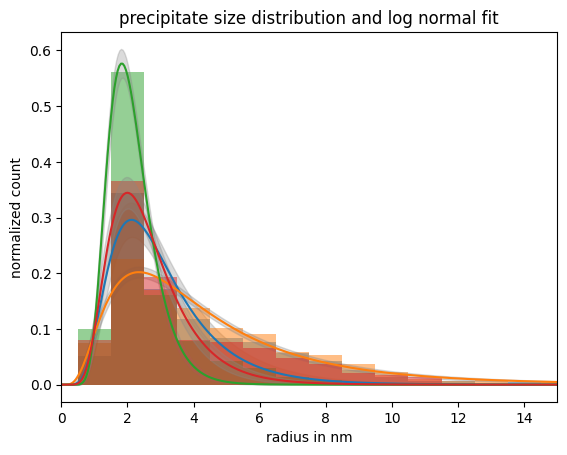

In [159]:
# plot all histograms and fitted lognormal distributions
model =models.LognormalModel()
title='precipitate size distribution and log normal fit'
for key, value in datatofit.items():
  print(key,value.columns) #width=bin_width, alpha=0.5, 
  plt.bar(value['center'], value['norm'], width=bin_width, alpha=0.5,align='center',label=key)
  # plt.plot(value[col_label_x],value[col_label_y],label=key)
  plt.title(title)
  plt.xlabel(plot_x_label)
  plt.ylabel(plot_y_label)
  plt.plot(fits[key]['x'], fits[key]['y'],label=key+'-fit')
  plt.fill_between(fits[key]['x'], fits[key]['y']-fits[key]['dely'],
                fits[key]['y']+fits[key]['dely'], color='#888888',alpha=0.3)
  plt.xlim([0.0, max_x])
  #plt.legend()
  tikzplotlib.save("{}.tex".format(title.replace(' ','_')))


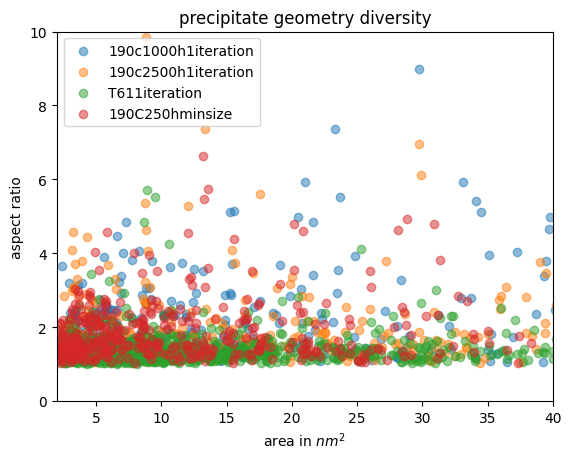

In [160]:
#visualize geometry diversity
title='precipitate geometry diversity'
for key, value in data.items():
  plt.scatter(x=data[key]['area_in_nm2'],y=data[key]['aspect_ratio'], alpha=0.5, label=key)
  plt.title(title)
  plt.xlabel(r'area in $nm^2$')
  plt.ylabel('aspect ratio')
  plt.xlim([2,40])
  plt.ylim([0,10])
plt.legend()
plt.show()  
#tikzplotlib.save("{}.tex".format(title.replace(' ','_')))
